In [ ]:
import sys

if not 'pandas' in sys.modules:
    !pip install -U 'pandas'==1.5.3
if not 'numpy' in sys.modules:
    !pip install -U 'numpy'==1.22.4
if not 'os' in sys.modules:
    !pip install -U 'os'       
if not 'glob' in sys.modules:
    !pip install -U 'glob'       
if not 'matplotlib' in sys.modules:
    !pip install -U 'matplotlib'      
if not 'seaborn' in sys.modules:
    !pip install -U 'seaborn'          
if not 're' in sys.modules:
    !pip install -U 're'   
if not 'scipy' in sys.modules:
    !pip install -U 'scipy'
if not 'haversine' in sys.modules:
    !pip install -U 'haversine'      

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy
from haversine import haversine, Unit
from os.path import join
from pathlib import Path

<h3>Global parameters</h3>
<ul>
    <li>Day [day]</li>
    <li>Time Window [tw]</li>
    <li>Connection duration [cd]</li>
    <li>Walking speed [ws]</li>
</ul>

In [2]:
day = 11
tw = 5
cd = [30, 1200]
ws = 1

<h3>Load tracking events and bus stop data</h3>
<p>Each event is a log that marks the passage of a bus through a bus stop. Firstly, everything is loaded, and second it is filtered from 6:00 to 19:59.</p>

In [9]:
def extract_terminal_name(x):
    if isinstance(x, str):
        pattern = r'Terminal (Capão da Imbuia|Pinheirinho|Portão|Bairro Alto|Barreirinha|Boa Vista|Boqueirão|Cabral|Cachoeira|Caiuá|Campina do Siqueira|Campo Comprido|Capão Raso|Carmo|Centenário|CIC|Fazendinha|Hauer|Maracanã|Oficinas|Pinhais|Santa Cândida|Santa Felicidade|Sítio Cercado|Tatuquara)'

        match = re.search(pattern, x)
        if match:
            return match.group()
    return x

# ----------------------------------------------------------
# Tracking events
# ----------------------------------------------------------
vw_event = pd.read_parquet("vw_event.parquet")
vw_event['hour'] = vw_event["event_timestamp"].dt.hour
vw_event['base_date'] = pd.to_datetime(vw_event["base_date"])
vw_event.query("6 <= hour <= 19", inplace = True)

# ----------------------------------------------------------
# Bus stops + normalization of names
# ----------------------------------------------------------
dim_bus_stop = pd.read_parquet("dim_bus_stop.parquet").query("type_norm not in (['Others','Dawn bus','Tourism line'])").drop(columns=['last_update'])
dim_bus_stop['name_normalized'] = np.where((dim_bus_stop.type_norm == 'Bus terminal'), dim_bus_stop.name, '')
dim_bus_stop['name_normalized'] = dim_bus_stop['name_normalized'].apply(extract_terminal_name)
dim_bus_stop['type_norm'] = np.where((dim_bus_stop.type_norm == 'Bus terminal'), 'Tube station', dim_bus_stop.type_norm)
terminais_dummy_ids = dim_bus_stop.query("~name_normalized.isna() and name_normalized != ''").groupby(['name_normalized']).agg(dummy_legacy_id = ('legacy_id', 'sum')).reset_index()
dim_bus_stop = dim_bus_stop.merge(terminais_dummy_ids, on=['name_normalized'], how='left')
dim_bus_stop['dummy_legacy_id'] = np.where( (dim_bus_stop.name_normalized == '') , dim_bus_stop.legacy_id, dim_bus_stop.dummy_legacy_id)
dim_bus_stop['dummy_legacy_id'] = dim_bus_stop.dummy_legacy_id.astype(int)

# ----------------------------------------------------------
# Consolidation of events + normalized points
# ----------------------------------------------------------
bs = dim_bus_stop.copy()
bs['name_normalized'] = np.where((bs.name_normalized == ''), bs.name, bs.name_normalized)
bs = bs.filter(['dummy_legacy_id', 'name_normalized', 'type_norm', 'latitude', 'longitude']).groupby(by = ['dummy_legacy_id', 'name_normalized', 'type_norm']).agg({'latitude': 'mean', 'longitude': 'mean'}).reset_index()
b = pd.merge(vw_event.filter(['line_code', 'itinerary_id', 'vehicle', 'legacy_id', 'seq', 'event_timestamp', 'base_date', 'month', 'day', 'weekday', 'hour']), dim_bus_stop.filter(['legacy_id', 'dummy_legacy_id']), left_on = 'legacy_id', right_on = 'legacy_id', how = 'left').drop(columns = ['legacy_id'])
events = pd.merge(b, bs)
events.dummy_legacy_id = events.dummy_legacy_id.astype('int')
events['year'] = events['event_timestamp'].dt.year
events['month'] = events['event_timestamp'].dt.month
events['day'] = events['event_timestamp'].dt.day
events['weekday'] = events['event_timestamp'].dt.weekday
events['hour'] = events['event_timestamp'].dt.hour
conditions = [
    ((events.hour >= 6) & ((events.hour <= 8))),
    ((events.hour >= 11) & ((events.hour <= 13))),
    ((events.hour >= 17) & ((events.hour <= 19)))
]
period_choices = ['Morning', 'Midday', 'Evening']
events['period'] = np.select(conditions, period_choices, default = 'N/A')
events.query(f'day == {day}', inplace = True)

<h3>Compute bus service</h3>
<p>The bus service is evaluated in a time window of <b>tw</b> minutes, representing an expected waiting time for most users. The number of buses of a line code that pass a stop is counted considering a time windows of <b>tw</b> minutes. This way, buses within a time window of <b>tw</b> minutes are counted. For each combination of bus stop and line code, a time series represents the number of buses observed in a <b>tw</b>-minute time interval during the day.</p>

In [10]:
events['time_window'] = (60 * events["event_timestamp"].dt.hour + events["event_timestamp"].dt.minute).floordiv(tw)
df_bus_availability = events.groupby(['dummy_legacy_id','line_code','year','month','day','weekday','hour','time_window']).size().reset_index(name = 'bus_count')
dim_bus_stop = events.filter(['dummy_legacy_id','line_code']).drop_duplicates()
dim_time = events.filter(['year','month','day','weekday','hour','time_window']).drop_duplicates()
df_bus_availability = pd.merge(pd.merge(dim_bus_stop, dim_time, how = 'cross'), df_bus_availability, how = 'left').fillna(0)
df_bus_availability = pd.merge(df_bus_availability, bs, on = "dummy_legacy_id")
period_choices = ['Morning', 'Midday', 'Evening']
conditions = [
    ((df_bus_availability.hour >= 6) & ((df_bus_availability.hour <= 8))),
    ((df_bus_availability.hour >= 11) & ((df_bus_availability.hour <= 13))),
    ((df_bus_availability.hour >= 17) & ((df_bus_availability.hour <= 19)))
]
df_bus_availability['period'] = np.select(conditions, period_choices, default = 'N/A')

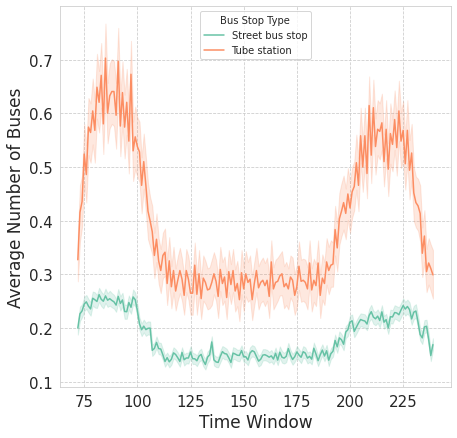

In [11]:
fig, axes = plt.subplots(figsize = (7, 7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.lineplot(x = df_bus_availability.time_window, y = df_bus_availability.bus_count, estimator = 'mean', errorbar = ('ci', 95), hue = df_bus_availability.type_norm, legend = True, palette = sns.color_palette("Set2", 2))
g.tick_params(labelsize = 15)
g.set_ylabel("Average Number of Buses", fontsize = 17)
g.set_xlabel("Time Window", fontsize = 17)
plt.legend(title = 'Bus Stop Type', loc = 'upper center');

<h3>Positive edges loading</h3>
<p>Firstly, everything is loaded, and second it is tagged by period:</p>
<ul>
    <li>Morning: 6:00 to 9:59 am</li>
    <li>Midday: 11:00 to 13:59</li>
    <li>Evening: 17:00 to 19:59</li>

In [12]:
parquet_files = glob.glob("connections_20min/*.parquet")
positive_edges = [pd.read_parquet(f) for f in parquet_files]
positive_edges = pd.concat(positive_edges, ignore_index = True)
positive_edges['event_timestamp_u'] =  pd.to_datetime(positive_edges["event_timestamp_u"])
positive_edges['event_timestamp_v'] =  pd.to_datetime(positive_edges["event_timestamp_v"])
positive_edges = positive_edges.groupby(by = ['dummy_legacy_id_u', 'dummy_legacy_id_v', 'line_code_u', 'line_code_v', 'vehicle_u', 'vehicle_v', 'event_timestamp_u']).event_timestamp_v.max().reset_index()
positive_edges['year'] = positive_edges['event_timestamp_u'].dt.year
positive_edges['month'] = positive_edges['event_timestamp_u'].dt.month
positive_edges['day'] = positive_edges['event_timestamp_u'].dt.day
positive_edges['weekday'] = positive_edges['event_timestamp_u'].dt.weekday
positive_edges['hour'] = positive_edges['event_timestamp_u'].dt.hour
positive_edges['base_date'] = pd.to_datetime(dict(year=positive_edges.year, month=positive_edges.month, day=positive_edges.day))
positive_edges['duration'] = (positive_edges.event_timestamp_v - positive_edges.event_timestamp_u).astype('timedelta64[s]')
positive_edges.drop_duplicates(inplace = True)

conditions = [
    ((positive_edges.event_timestamp_v.dt.hour >= 6) & ((positive_edges.event_timestamp_v.dt.hour <= 8))),
    ((positive_edges.event_timestamp_v.dt.hour >= 11) & ((positive_edges.event_timestamp_v.dt.hour <= 13))),
    ((positive_edges.event_timestamp_v.dt.hour >= 17) & ((positive_edges.event_timestamp_v.dt.hour <= 19)))
]

period_choices = ['Morning', 'Midday', 'Evening']
positive_edges['period'] = np.select(conditions, period_choices, default = 'N/A')
positive_edges.query(f'day == {day}', inplace = True)

positive_edges['time_window'] = (60 * positive_edges["event_timestamp_v"].dt.hour + positive_edges["event_timestamp_v"].dt.minute).floordiv(tw)
positive_edges['group_id'] = positive_edges.groupby(by = ['dummy_legacy_id_u', 'dummy_legacy_id_v', 'line_code_u', 'line_code_v']).ngroup()

<h3>Filter positive edges by feasible walking time</h3>

In [14]:
def dist(connection):
    u = list(bs.query(f"dummy_legacy_id == {connection['dummy_legacy_id_u']}")[['latitude', 'longitude']].itertuples(index=False, name=None))[0]
    v = list(bs.query(f"dummy_legacy_id == {connection['dummy_legacy_id_v']}")[['latitude', 'longitude']].itertuples(index=False, name=None))[0]
    dist = haversine(u, v, unit = Unit.METERS)
    return dist

distance = positive_edges[['dummy_legacy_id_u', 'dummy_legacy_id_v']].drop_duplicates()
distance['walking_distance'] = distance.apply(lambda row: dist(row), axis = 1);
positive_edges = pd.merge(positive_edges, distance)
positive_edges['walking_time'] = positive_edges.walking_distance / ws
positive_edges.query('walking_time < duration', inplace = True)

<h3>Crossing positive edges and bus availability</h3>

In [15]:
pe = positive_edges.query(f"duration >= {cd[0]} and duration <= {cd[1]}").copy()
pe = pe.groupby(['dummy_legacy_id_u', 'dummy_legacy_id_v', 'line_code_u', 'line_code_v', 'group_id']).size().reset_index(name='conn_count')
ba = df_bus_availability.copy()
ba = ba.groupby(['dummy_legacy_id', 'line_code']).bus_count.sum().reset_index()
df_analise_edges = pd.merge(pe, ba, left_on = ['dummy_legacy_id_u', 'line_code_u'], right_on = ['dummy_legacy_id', 'line_code'], how = 'inner')
df_analise_edges = pd.merge(df_analise_edges, ba, left_on = ['dummy_legacy_id_v', 'line_code_v'], right_on = ['dummy_legacy_id', 'line_code'], how = 'inner')
df_analise_edges.rename(columns = {'bus_count_x': 'bus_count_u', 'bus_count_y': 'bus_count_v'}, inplace = True)
df_analise_edges.drop(columns = ['dummy_legacy_id_x', 'dummy_legacy_id_y', 'line_code_x', 'line_code_y'], axis = 1, inplace = True)
df_analise_edges['min_bus_count'] = df_analise_edges.filter(['bus_count_u', 'bus_count_v']).min(axis = 1)

In [16]:
from sklearn.preprocessing import MinMaxScaler

# Normalizando a coluna 'freq' pela coluna 'stop_count'
df_analise_edges['conn_count_normalized'] = df_analise_edges['conn_count'] / df_analise_edges['min_bus_count']

# Aplicando Min-Max Scaling para garantir que os valores estejam entre 0 e 1
scaler = MinMaxScaler()
df_analise_edges['conn_count_normalized'] = scaler.fit_transform(df_analise_edges[['conn_count_normalized']])

# Visualizar as primeiras linhas do DataFrame para conferir a normalização
df_analise_edges.head()

,dummy_legacy_id_u,dummy_legacy_id_v,line_code_u,line_code_v,group_id,conn_count,bus_count_u,bus_count_v,min_bus_count,conn_count_normalized
0,101004,101005,876,207,0,41,34.0,53.0,34.0,0.180477
1,101005,101005,260,207,64,18,12.0,53.0,12.0,0.226006
2,101121,101005,901,207,225,64,59.0,53.0,53.0,0.180735
3,101131,101005,160,207,350,20,21.0,53.0,21.0,0.141235
4,101131,101005,164,207,352,24,22.0,53.0,22.0,0.162679


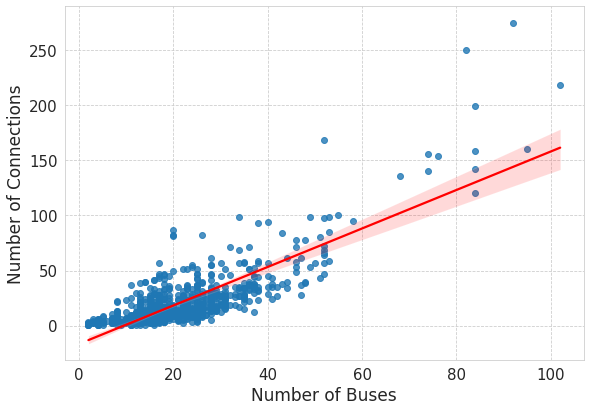

In [62]:
x = df_analise_edges.sample(n = 1000)
fig, axes = plt.subplots(figsize = (9.3, 6.5))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.regplot(x = x.min_bus_count, y = x.conn_count, ci = 95, ax = axes, line_kws = {'color': 'red'})
g.tick_params(labelsize = 15)
g.set_xlabel("Number of Buses", fontsize = 17)
g.set_ylabel("Number of Connections", fontsize = 17);

In [63]:
scipy.stats.pearsonr(x = x.min_bus_count, y = x.conn_count)

(0.8230137764461725, 2.2010477204743197e-247)

In [64]:
x['min_bus_count_group'] = 5 * (1 + x.min_bus_count / 5).astype('int32')

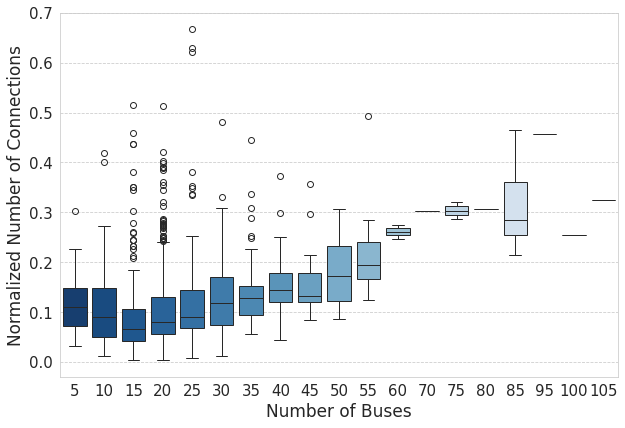

In [71]:
fig, axes = plt.subplots(figsize = (10, 6.7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.boxplot(x = x.min_bus_count_group, y = x.conn_count_normalized, linewidth = 1.0, palette = sns.color_palette("Blues_r", len(x.min_bus_count_group.unique())), hue = x.min_bus_count_group, notch = False, showfliers = True, ax = axes, legend = False)
g.tick_params(labelsize = 15)
g.set_xlabel("Number of Buses", fontsize = 17)
g.set_ylabel("Normalized Number of Connections", fontsize = 17);

In [66]:
x.sort_values('conn_count_normalized', ascending = False).head(50)

,dummy_legacy_id_u,dummy_legacy_id_v,line_code_u,line_code_v,group_id,conn_count,bus_count_u,bus_count_v,min_bus_count,conn_count_normalized,min_bus_count_group
57193,108041,108042,603,202,7816,87,131.0,20.0,20.0,0.667183,25
60630,108053,108053,603,202,9266,82,129.0,20.0,20.0,0.628483,25
39298,108024,108024,202,200,4031,81,20.0,102.0,20.0,0.620743,25
101511,108167,108167,302,303,12743,37,11.0,107.0,11.0,0.514495,15
51829,150634,108037,674,603,129807,57,17.0,132.0,17.0,0.512839,20
121253,109048,130128,022,020,20184,168,130.0,52.0,52.0,0.493927,55
36327,109030,109030,507,702,18391,82,141.0,26.0,26.0,0.482020,30
68741,108212,108212,502,550,14067,250,82.0,119.0,82.0,0.465755,85
42331,108213,109074,550,X36,14105,39,123.0,13.0,13.0,0.458204,15
58923,108052,108052,603,602,8951,275,125.0,92.0,92.0,0.456522,95


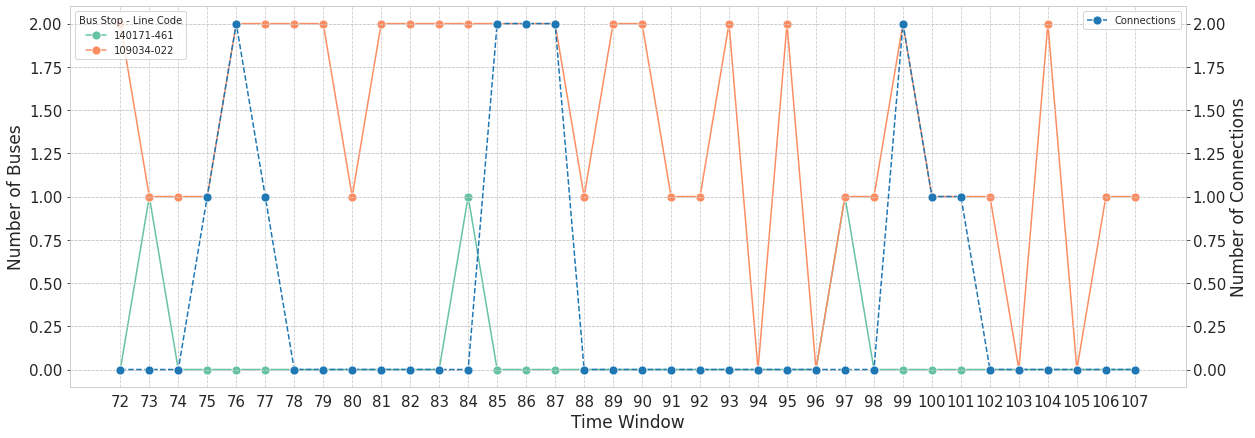

In [67]:
group_id = 92228
period = 'Morning'

edge_info = df_analise_edges.query(f"group_id == {group_id}")
if (edge_info['bus_count_u'] < edge_info['bus_count_v']).bool():
    minor_id = list(edge_info[['dummy_legacy_id_u', 'line_code_u']].itertuples(index=False, name=None))[0]
    bigger_id = list(edge_info[['dummy_legacy_id_v', 'line_code_v']].itertuples(index=False, name=None))[0]
else:
    minor_id = list(edge_info[['dummy_legacy_id_v', 'line_code_v']].itertuples(index=False, name=None))[0]
    bigger_id = list(edge_info[['dummy_legacy_id_u', 'line_code_u']].itertuples(index=False, name=None))[0]

ba = df_bus_availability.query(f"period == '{period}'").copy()
df0 = ba.query(f"(dummy_legacy_id == {minor_id[0]} and line_code == '{minor_id[1]}') or (dummy_legacy_id == {bigger_id[0]} and line_code == '{bigger_id[1]}')").copy()
df0['label'] = df0['dummy_legacy_id'].astype(str) + "-" + df0['line_code']
pe = positive_edges.query(f"period == '{period}' and group_id == {group_id} and duration >= {cd[0]} and duration <= {cd[1]}").copy()
pe['time_window'] = (60 * pe["event_timestamp_v"].dt.hour + pe["event_timestamp_v"].dt.minute).floordiv(tw)
df1 = pd.merge(df0.time_window.drop_duplicates(), pe.groupby('time_window').size().reset_index(name='conn_count'), how = 'left').fillna(0)

fig, axes = plt.subplots(figsize = (20, 7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g0 = sns.lineplot(x = df0.time_window, y = df0.bus_count, estimator = 'mean', errorbar = ('ci', 95), hue = df0.label, hue_order = ["%s-%s" % (minor_id[0], minor_id[1]), "%s-%s" % (bigger_id[0], bigger_id[1])], legend = True, palette = sns.color_palette("Set2", 2), marker = 'o', markersize = 9, linestyle = "solid",)
g0.tick_params(labelsize = 15)
g0.set_ylabel("Number of Buses", fontsize = 17)
g0.set_xlabel("Time Window", fontsize = 17)
g0.set_xticks(df0.time_window.drop_duplicates())
plt.legend(title = 'Bus Stop - Line Code', loc = 'upper left')

g1 = sns.lineplot(x = df1.time_window, y = df1.conn_count, marker = 'o', markersize = 9, linestyle = "dashed", ax = g0.axes.twinx(), label = 'Connections')
g1.tick_params(labelsize = 15)
g1.set_ylabel("Number of Connections", fontsize = 17);

# Ajustando a escala do eixo y
ymin = min(g0.get_ylim()[0], g1.get_ylim()[0])
ymax = max(g0.get_ylim()[1], g1.get_ylim()[1])

g0.set_ylim(ymin, ymax)
g1.set_ylim(ymin, ymax);

<h3>Build dataset to send to LSTM</h3>

In [164]:
def build_dataset(group_id):
    edge_info = df_analise_edges.query(f"group_id == {group_id}")
    if (edge_info['bus_count_u'] < edge_info['bus_count_v']).bool():
        minor_id = list(edge_info[['dummy_legacy_id_u', 'line_code_u']].itertuples(index=False, name=None))[0]
        bigger_id = list(edge_info[['dummy_legacy_id_v', 'line_code_v']].itertuples(index=False, name=None))[0]
    else:
        minor_id = list(edge_info[['dummy_legacy_id_v', 'line_code_v']].itertuples(index=False, name=None))[0]
        bigger_id = list(edge_info[['dummy_legacy_id_u', 'line_code_u']].itertuples(index=False, name=None))[0]
    minor_df = df_bus_availability.query(f"dummy_legacy_id == {minor_id[0]} and line_code == '{minor_id[1]}'").filter(['time_window', 'bus_count']).copy()
    minor_df['series'] = 'minor'
    bigger_df = df_bus_availability.query(f"dummy_legacy_id == {bigger_id[0]} and line_code == '{bigger_id[1]}'").filter(['time_window', 'bus_count']).copy()
    bigger_df['series'] = 'bigger'
    bus_count_df = pd.concat([minor_df, bigger_df], ignore_index = True)
    bus_count_df.rename({'bus_count': 'value'}, axis = 1, inplace = True)
    pe = positive_edges.query(f"group_id == {group_id} and duration >= {cd[0]} and duration <= {cd[1]}").copy()
    pe['time_window'] = (60 * pe["event_timestamp_v"].dt.hour + pe["event_timestamp_v"].dt.minute).floordiv(tw)
    pe_df = pd.merge(bus_count_df.time_window.drop_duplicates(), pe.groupby('time_window').size().reset_index(name='conn_count'), how = 'left').fillna(0)
    pe_df['series'] = 'connection'
    pe_df.rename({'conn_count': 'value'}, axis = 1, inplace = True)
    lstm_df = pd.concat([bus_count_df, pe_df], ignore_index = True)
    lstm_df['group_id'] = group_id
    return lstm_df

In [165]:
build_dataset(199092)

,time_window,value,series,group_id
0,72,0.0,minor,199092
1,88,0.0,minor,199092
2,105,0.0,minor,199092
3,119,1.0,minor,199092
4,136,0.0,minor,199092
...,...,...,...,...
499,151,0.0,connection,199092
500,232,0.0,connection,199092
501,132,0.0,connection,199092
502,145,0.0,connection,199092


In [175]:
lstm_dfs = []
c = 0
for group_id in x.group_id:
    lstm_dfs.append(build_dataset(group_id))
    c = c + 1
    print("%d / %d" % (c, len(x.group_id)))

1 / 1000
2 / 1000
3 / 1000
4 / 1000
5 / 1000
6 / 1000
7 / 1000
8 / 1000
9 / 1000
10 / 1000
11 / 1000
12 / 1000
13 / 1000
14 / 1000
15 / 1000
16 / 1000
17 / 1000
18 / 1000
19 / 1000
20 / 1000
21 / 1000
22 / 1000
23 / 1000
24 / 1000
25 / 1000
26 / 1000
27 / 1000
28 / 1000
29 / 1000
30 / 1000
31 / 1000
32 / 1000
33 / 1000
34 / 1000
35 / 1000
36 / 1000
37 / 1000
38 / 1000
39 / 1000
40 / 1000
41 / 1000
42 / 1000
43 / 1000
44 / 1000
45 / 1000
46 / 1000
47 / 1000
48 / 1000
49 / 1000
50 / 1000
51 / 1000
52 / 1000
53 / 1000
54 / 1000
55 / 1000
56 / 1000
57 / 1000
58 / 1000
59 / 1000
60 / 1000
61 / 1000
62 / 1000
63 / 1000
64 / 1000
65 / 1000
66 / 1000
67 / 1000
68 / 1000
69 / 1000
70 / 1000
71 / 1000
72 / 1000
73 / 1000
74 / 1000
75 / 1000
76 / 1000
77 / 1000
78 / 1000
79 / 1000
80 / 1000
81 / 1000
82 / 1000
83 / 1000
84 / 1000
85 / 1000
86 / 1000
87 / 1000
88 / 1000
89 / 1000
90 / 1000
91 / 1000
92 / 1000
93 / 1000
94 / 1000
95 / 1000
96 / 1000
97 / 1000
98 / 1000
99 / 1000
100 / 1000
101 / 10

757 / 1000
758 / 1000
759 / 1000
760 / 1000
761 / 1000
762 / 1000
763 / 1000
764 / 1000
765 / 1000
766 / 1000
767 / 1000
768 / 1000
769 / 1000
770 / 1000
771 / 1000
772 / 1000
773 / 1000
774 / 1000
775 / 1000
776 / 1000
777 / 1000
778 / 1000
779 / 1000
780 / 1000
781 / 1000
782 / 1000
783 / 1000
784 / 1000
785 / 1000
786 / 1000
787 / 1000
788 / 1000
789 / 1000
790 / 1000
791 / 1000
792 / 1000
793 / 1000
794 / 1000
795 / 1000
796 / 1000
797 / 1000
798 / 1000
799 / 1000
800 / 1000
801 / 1000
802 / 1000
803 / 1000
804 / 1000
805 / 1000
806 / 1000
807 / 1000
808 / 1000
809 / 1000
810 / 1000
811 / 1000
812 / 1000
813 / 1000
814 / 1000
815 / 1000
816 / 1000
817 / 1000
818 / 1000
819 / 1000
820 / 1000
821 / 1000
822 / 1000
823 / 1000
824 / 1000
825 / 1000
826 / 1000
827 / 1000
828 / 1000
829 / 1000
830 / 1000
831 / 1000
832 / 1000
833 / 1000
834 / 1000
835 / 1000
836 / 1000
837 / 1000
838 / 1000
839 / 1000
840 / 1000
841 / 1000
842 / 1000
843 / 1000
844 / 1000
845 / 1000
846 / 1000
847 / 1000

In [248]:
df = pd.concat(lstm_dfs)
df = df.pivot(index = ['group_id', 'time_window'], columns = 'series', values = 'value').reset_index()
df.filter(['group_id', 'time_window', 'minor', 'bigger', 'connection']).to_parquet('lstm_dfs.parquet', index = None)

In [249]:
pd.read_parquet('lstm_dfs.parquet')

series,group_id,time_window,minor,bigger,connection
0,333,72,0.0,0.0,0.0
1,333,73,0.0,0.0,0.0
2,333,74,0.0,0.0,0.0
3,333,75,0.0,1.0,0.0
4,333,76,1.0,0.0,1.0
...,...,...,...,...,...
167995,198553,235,0.0,1.0,0.0
167996,198553,236,0.0,0.0,0.0
167997,198553,237,1.0,0.0,1.0
167998,198553,238,0.0,0.0,0.0
